# **Using Natural Language Processing to predict if the tweets are real or not**
Dataset link = https://www.kaggle.com/c/nlp-getting-started/data 

In [1]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"


from helper_functions import *

unzip_data("nlp_getting_started.zip")

--2021-11-09 01:35:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2021-11-09 01:35:29 (80.9 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]

--2021-11-09 01:35:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [2]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**Pre processing data**

In [4]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

**Building Custom Text Vectorizer model**

In [5]:

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long should the output sequence of tokens be?
                                    )
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)
text_vectorizer.adapt(train_sentences)

In [6]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


**Building custom embedding layer based on vocabulary available**

In [7]:

from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input


In [8]:
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I added a video to a @YouTube playlist http://t.co/bcjYleRRYX Ori and the Bind forest ep 6 'Fire and death'      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01006157,  0.01183497,  0.00228188, ..., -0.00199648,
         -0.04229118,  0.0008131 ],
        [-0.02285802,  0.02170334,  0.01093993, ...,  0.00857978,
          0.02893255, -0.03940213],
        [-0.04373548,  0.04821594,  0.01130601, ...,  0.0400458 ,
          0.02680952,  0.04841613],
        ...,
        [-0.008319  , -0.0497268 ,  0.01943761, ..., -0.03108682,
         -0.02022816,  0.03449004],
        [-0.03409195,  0.03103853,  0.02599326, ..., -0.04754407,
         -0.03045726,  0.03502897],
        [-0.02906351, -0.02395953, -0.03820252, ..., -0.01187805,
         -0.01476844,  0.02150441]]], dtype=float32)>

**Making a basic classification with one output by using MaxPooling**

In [9]:
epoks = 15

In [10]:
logz = "logzzz"

import tensorflow as tf
from tensorflow.keras import layers

In [11]:
ins = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(ins)
x = embedding(x)
x = layers.GlobalMaxPooling1D()(x)
outs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(ins,outs)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [14]:
track1 = model_1.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","uno")])

Saving TensorBoard log files to: trainin/uno/20211109-013533
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.6362 - accuracy: 0.6538 - val_loss: 0.5718 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4674 - accuracy: 0.8272 - val_loss: 0.4714 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3406 - accuracy: 0.8740 - val_loss: 0.4513 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2575 - accuracy: 0.9085 - val_loss: 0.4508 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1986 - accuracy: 0.9320 - val_loss: 0.4616 - val_accuracy: 0.7927


Plotting loss curves

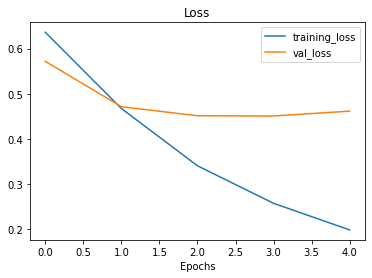

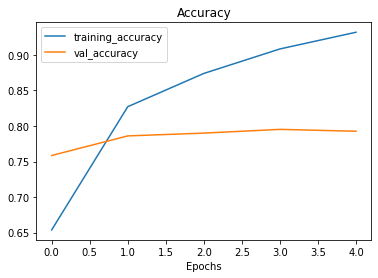

In [15]:
plot_loss_curves(track1)

In [16]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.42011425],
       [0.816369  ],
       [0.9933651 ],
       [0.06171225],
       [0.2917188 ],
       [0.961784  ],
       [0.9197166 ],
       [0.98952776],
       [0.9274107 ],
       [0.11831915]], dtype=float32)

Model Result Analysis

In [17]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.26509186351706,
 'f1': 0.7897346702572751,
 'precision': 0.7977980796415257,
 'recall': 0.7926509186351706}

**Experimenting a classification model using LTSM**

In [18]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inp)
x = embedding(x)
x = layers.LSTM(64,return_sequences= True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64,activation = "relu")(x)
outz = layers.Dense(1,activation="sigmoid")(x)

model_2= tf.keras.Model(inp,outz)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 15, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65  

In [19]:
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
track2 = model_2.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","dos")])

Saving TensorBoard log files to: trainin/dos/20211109-013547
Epoch 1/5
215/215 [==============================] - 11s 23ms/step - loss: 0.3768 - accuracy: 0.8441 - val_loss: 0.4678 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2449 - accuracy: 0.9031 - val_loss: 0.5278 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1799 - accuracy: 0.9340 - val_loss: 0.5478 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1511 - accuracy: 0.9472 - val_loss: 0.7186 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1075 - accuracy: 0.9612 - val_loss: 1.0495 - val_accuracy: 0.7612


Plotting loss curves

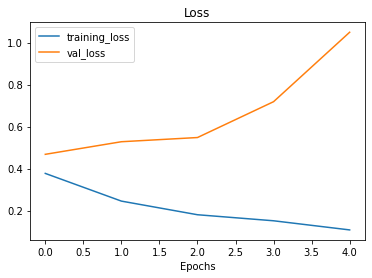

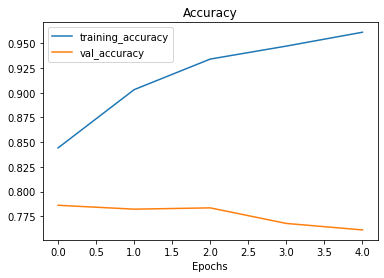

In [20]:
plot_loss_curves(track2)

Model Results Analysis

In [21]:
model_1_pred_probs = model_2.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.11548556430446,
 'f1': 0.7602537798972311,
 'precision': 0.7608818684574628,
 'recall': 0.7611548556430446}

**Experimenting with model using both LTSM and GRU**

In [22]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inp)
x = embedding(x)
x = layers.GRU(64,return_sequences= True)(x)
x = layers.LSTM(64,return_sequences= True)(x)
x = layers.GRU(64,return_sequences= True)(x)
x = layers.GlobalAveragePooling1D()(x)
outz = layers.Dense(1,activation="sigmoid")(x)

model_3= tf.keras.Model(inp,outz)
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            37248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0   

In [23]:
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
track3 = model_3.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","tres")])

Saving TensorBoard log files to: trainin/tres/20211109-013615
Epoch 1/5
215/215 [==============================] - 12s 30ms/step - loss: 0.1979 - accuracy: 0.9186 - val_loss: 0.6838 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1106 - accuracy: 0.9600 - val_loss: 0.9145 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0801 - accuracy: 0.9666 - val_loss: 1.0573 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0650 - accuracy: 0.9710 - val_loss: 1.1477 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0579 - accuracy: 0.9734 - val_loss: 1.5377 - val_accuracy: 0.7651


Plotting loss curves

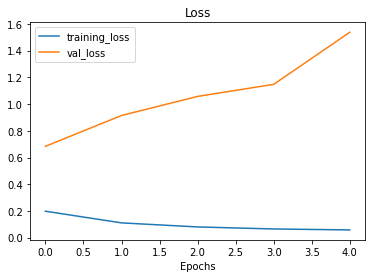

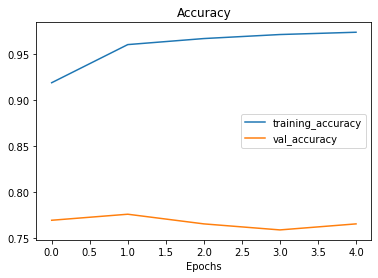

In [24]:
plot_loss_curves(track3)

Model Results Analysis

In [25]:
model_1_pred_probs = model_3.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.50918635170603,
 'f1': 0.7627590065822708,
 'precision': 0.7669456967235844,
 'recall': 0.7650918635170604}

**Experimenting with Bidirectional LTSM and GRU**

In [26]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inp)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64,return_sequences= True))(x)
x = layers.Bidirectional(layers.LSTM(64,return_sequences= True))(x)
x = layers.Bidirectional(layers.GRU(64,return_sequences= True))(x)
x = layers.GlobalAveragePooling1D()(x)
outz = layers.Dense(1,activation="sigmoid")(x)

model_4= tf.keras.Model(inp,outz)
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           74496     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 128)           74496     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0   

In [27]:
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
track4 = model_4.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","tres")])

Saving TensorBoard log files to: trainin/tres/20211109-013648
Epoch 1/5
215/215 [==============================] - 21s 51ms/step - loss: 0.1275 - accuracy: 0.9510 - val_loss: 0.9998 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0632 - accuracy: 0.9727 - val_loss: 1.5372 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0544 - accuracy: 0.9746 - val_loss: 1.5318 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0463 - accuracy: 0.9774 - val_loss: 1.4750 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0496 - accuracy: 0.9764 - val_loss: 1.4649 - val_accuracy: 0.7638


Plotting loss curves

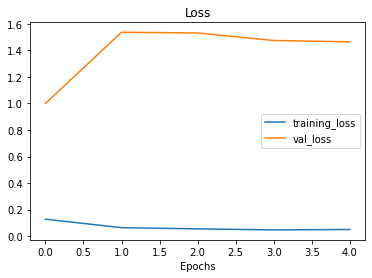

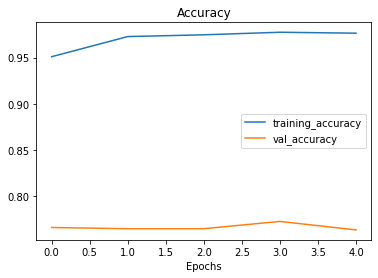

In [28]:
plot_loss_curves(track4)

Model Results Analysis

In [29]:
model_1_pred_probs = model_4.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.37795275590551,
 'f1': 0.7599542443739118,
 'precision': 0.768889469729147,
 'recall': 0.7637795275590551}

**Experimenting with 1 dimensional Convolution neural network for Natural Language Processing**

In [30]:
inp = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inp)
x = embedding(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(64,5,1,activation="relu",padding="same")(x)
x = layers.MaxPool1D()(x)
outz = layers.Dense(1,activation="sigmoid")(x)

model_5= tf.keras.Model(inp,outz)
model_5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0   

In [31]:
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
track5 = model_5.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","pento")])

Saving TensorBoard log files to: trainin/pento/20211109-013742
Epoch 1/5
215/215 [==============================] - 30s 16ms/step - loss: 0.1098 - accuracy: 0.9610 - val_loss: 1.0774 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0511 - accuracy: 0.9774 - val_loss: 1.4313 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0418 - accuracy: 0.9791 - val_loss: 1.6088 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0395 - accuracy: 0.9810 - val_loss: 1.5429 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0382 - accuracy: 0.9815 - val_loss: 1.6428 - val_accuracy: 0.7572


Plotting Loss Curves

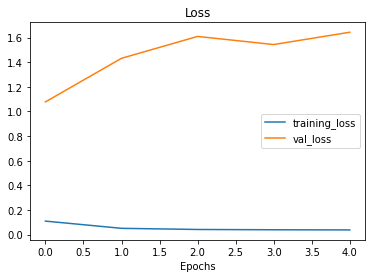

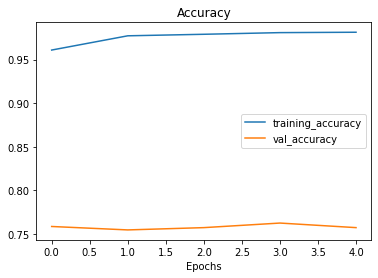

In [32]:
plot_loss_curves(track5)

Model Results Analysis

In [33]:
model_1_pred_probs = model_4.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 75.8530183727034,
 'f1': 0.7549664582215014,
 'precision': 0.7625739943565455,
 'recall': 0.7585301837270341}

**Experimenting with Universal Sentence Encoder**

In [34]:
import tensorflow_hub as hub
sEnc = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                      input_shape=[],
                      dtype = tf.string)

In [35]:
model_6 = tf.keras.Sequential([
                               sEnc,
                               layers.Dense(64,activation="relu"),
                               layers.Dense(1,activation="sigmoid")
])
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [36]:
track6 = model_6.fit(train_sentences,train_labels, epochs = 5,
                   validation_data = (val_sentences,val_labels),
                   callbacks = [create_tensorboard_callback("trainin","hexxa")])

Saving TensorBoard log files to: trainin/hexxa/20211109-013845
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5056 - accuracy: 0.7758 - val_loss: 0.4498 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4152 - accuracy: 0.8151 - val_loss: 0.4395 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4011 - accuracy: 0.8248 - val_loss: 0.4317 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3918 - accuracy: 0.8260 - val_loss: 0.4292 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3842 - accuracy: 0.8300 - val_loss: 0.4240 - val_accuracy: 0.8176


Plotting loss curves

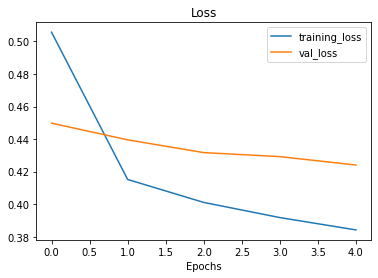

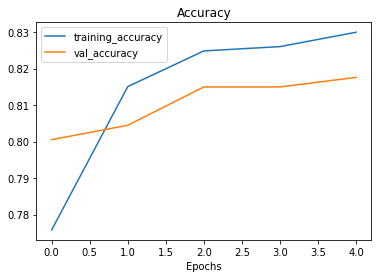

In [37]:
plot_loss_curves(track6)

Analysing Model results

In [38]:
model_1_pred_probs = model_6.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.75853018372703,
 'f1': 0.8164548892316194,
 'precision': 0.8188543841314186,
 'recall': 0.8175853018372703}

**Training on the Entire dataset with the best model**

In [39]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [40]:
model_7 = tf.keras.models.clone_model(model_6)
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [42]:
track7 = model_7.fit(train_sentences_90_percent,train_labels_90_percent, epochs = 15,
                   validation_data = (train_sentences_10_percent,train_labels_10_percent),
                   callbacks = [create_tensorboard_callback("trainin","idkwatz7")])

Saving TensorBoard log files to: trainin/idkwatz7/20211109-013959
Epoch 1/15
193/193 [==============================] - 5s 25ms/step - loss: 0.3932 - accuracy: 0.8268 - val_loss: 0.3985 - val_accuracy: 0.8120
Epoch 2/15
193/193 [==============================] - 4s 22ms/step - loss: 0.3870 - accuracy: 0.8292 - val_loss: 0.3927 - val_accuracy: 0.8236
Epoch 3/15
193/193 [==============================] - 4s 22ms/step - loss: 0.3813 - accuracy: 0.8339 - val_loss: 0.3994 - val_accuracy: 0.8105
Epoch 4/15
193/193 [==============================] - 5s 24ms/step - loss: 0.3739 - accuracy: 0.8352 - val_loss: 0.3904 - val_accuracy: 0.8207
Epoch 5/15
193/193 [==============================] - 4s 22ms/step - loss: 0.3672 - accuracy: 0.8394 - val_loss: 0.3884 - val_accuracy: 0.8236
Epoch 6/15
193/193 [==============================] - 4s 21ms/step - loss: 0.3619 - accuracy: 0.8404 - val_loss: 0.3940 - val_accuracy: 0.8163
Epoch 7/15
193/193 [==============================] - 4s 23ms/step - loss: 0

Plotting Loss Curves

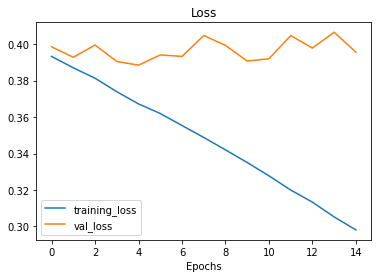

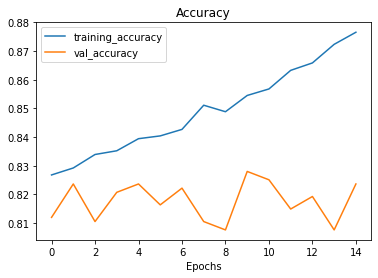

In [43]:
plot_loss_curves(track7)

Analysing Model Results

In [44]:
model_1_pred_probs = model_7.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.49606299212599,
 'f1': 0.813013156274745,
 'precision': 0.8186374796992019,
 'recall': 0.8149606299212598}